# TESLA Stock Price Prediciton using Historical Stock Data and Sentiment Analysis

## Project Overview

This project aims to enhance the accuracy of predicting future Tesla stock prices by incorporating sentiment anlaysis from Twitter data.

In the methodology, we construct a rolling window of a certain number of days from the historical stock data. Each window encapsulates a sequence of past trading days, including features such as open, close, low and high prices, as well as trading volume. The LSTM model is trained on these sequential windows to predict the future closing price of Tesla stock.

Then, the sentiments of tweets relating to Tesla are analysed and the sentiment score is included in our historical stock data. By incorporating sentiment alongside historical stock data the accuracy of the model is improved.

The structure is as follows:

1) [Importing Libraries](#Importing-Libraries)

2) [Stock Analysis](#Stock-Analysis)

3) [Sentiment Analysis](#Sentiment-Analysis)

4) [Conclusions](#Conclusions)

## Importing Libraries

In this section we import all the libraries needed. These are split into timing and date libraries, data collection and preprocessing libraries, visualisation libraries, machine learning libraries and sentiment analysis libraries.

In [169]:
# Timing and date
import time
import datetime as dt

# Data Collection and Preprocessing
import yfinance as yf
import pandas as pd
import datetime
import numpy as np

# Visualisation
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import mean_squared_error
from hyperopt.pyll.base import scope

# Sentiment analysis
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob

## Stock Analysis

In this section we try to predict future Tesla close prices based on historical stock data only. 

The structure is as follows:

1) [Data Acquisition and Preprocessing](#Data-Acquisition-and-Preprocessing)

2) [Exploratory Data Analysis](#Exploratory-Data-Analysis)

3) [Model Selection and Training](#Model-Selection-and-Training)

### Data Acquisition and Preprocessing

In this section we acquire the Tesla stock data. Using yfinance there is no need to do any preprocessing of the data since holidays and days of no trading are not included.

The structure is as follows:

1) [Acquiring Data](#Acquiring-Data)

#### Acquiring Data

In this section we acquire our stock data. We use yfinance to download historical Tesla stock data. We use auto_adjust = True as this adjust downloaded prices automatically for splits, dividends and other corporate actions, removing preprocessing steps.

We also specify the date ranges for historical data used. Feel free to change these, in fact, including more data would likely improve the accuracy of the model.

However, the start date has been chosen as 01/01/2020 and the end date as 01/01/2021 as this is the only available date range of tweets about Tesla. Since Elon Musk has taken over Twitter, obtaining tweets using the Twitter API is incredibly limited/expensive and this year of tweet data about Tesla is the only data available. So changing these years will not affect stock analysis functionality but will affect sentiment analysis.

We convert this data into a dataframe and specify relevant columns and colours for plots. 

In [170]:
# Set display options to show four decimal places
pd.set_option('display.float_format', '{:.4f}'.format)

# Download Tesla data using yfinance
ticker = 'TSLA'
# Auto_adjust set to true to account for stock splits and dividends
data = yf.download(ticker, auto_adjust=True)

# Convert downloaded data into a Pandas DataFrame
tsla_df = pd.DataFrame(data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Start date for Tesla stock prices
start_date = '2020-01-01'

# End date for Tesla stock prices
end_date = '2021-01-01'

# Select specific data based on date range
tsla_df = tsla_df.loc[start_date : end_date]

# Columns indicating price
price_columns = ['Open', 'High', 'Low', 'Close']

# Plot colours for Open, High, Low and Close respectively
price_colours = ['#828cf8', '#ef553b', '#00cc96', '#b983f8']

# Colour for volume plots
volume_colour = '#ffa500'

[*********************100%%**********************]  1 of 1 completed


In [171]:
tsla_df.head()

Open    High     Low   Close     Volume
Date                                                 
2020-01-02 28.3000 28.7133 28.1140 28.6840  142981500
2020-01-03 29.3667 30.2667 29.1280 29.5340  266677500
2020-01-06 29.3647 30.1040 29.3333 30.1027  151995000
2020-01-07 30.7600 31.4420 30.2240 31.2707  268231500
2020-01-08 31.5800 33.2327 31.2153 32.8093  467164500

In [172]:
tsla_df.tail()

Open     High      Low    Close     Volume
Date                                                     
2020-12-24 214.3300 222.0300 213.6667 220.5900   68596800
2020-12-28 224.8367 227.1333 220.2667 221.2300   96835800
2020-12-29 220.3333 223.3000 218.3333 221.9967   68732400
2020-12-30 224.0000 232.2000 222.7867 231.5933  128538000
2020-12-31 233.3300 239.5733 230.3733 235.2233  148949700

### Exploratory Data Analysis

In this section we explore the historical Tesla stock data, highlighting aspects such as key statistics, distribution of prices and volume, trends over time and correlation among variables.

The structure is as follows:

1) [Key Statistics](#Key-Statistics)

2) [Distributions](#Distributions)

3) [Trends over Time](#Trends-over-Time)

4) [Correlations among Variables](#Correlations-among-Variables)

#### Key Statistics

In this section we examine key statistics, measures such as mean, standard deviation, minimum and maximum and percentiles for both prices and volume.

In [173]:
tsla_df.describe()

Open     High      Low    Close         Volume
count 253.0000 253.0000 253.0000 253.0000       253.0000
mean   96.3695  99.0961  93.5660  96.6657 225923862.4506
std    55.8885  57.2343  54.4501  56.3319 120411185.0238
min    24.9800  26.9907  23.3673  24.0813  52073100.0000
25%    49.4560  51.6633  47.7407  49.9307 141403500.0000
50%    81.4320  81.8667  79.0400  80.5773 210766500.0000
75%   140.4633 143.5000 136.8600 140.4000 283636500.0000
max   233.3300 239.5733 230.3733 235.2233 914082000.0000

In [174]:
# Create a list of Box traces for Price columns 
price_box_traces = []

for i, column in enumerate(price_columns):
    price_box_traces.append(go.Box(y=tsla_df[column],
                                   name=column,
                                  marker=dict(color=price_colours[i])))

# Create the figure and add the traces
fig = go.Figure(data=price_box_traces)

# Update the layout
fig.update_layout(
    title='Box Plot of Tesla Stock Prices',
    yaxis_title='Price ($)'
)

# Show the plot
fig.show()

From the above box plot we see a large range in Tesla values between 2020 and 2021. However, we see an average price of around $75 for each open, high, low and close feature.
This is likely because during 2020 Tesla was becoming more prominent with their disruptive technologies and began to rise steadily. However, on December 21st 2020 Tesla was added to the S&P 500 causing a large shoot up in price, hence the large maximum values.

In [175]:
# Create Box trace for Volume
volume_box_trace = go.Box(y=tsla_df['Volume'],
                          name='Volume',
                         marker=dict(color=volume_colour))

# Create the figure and add the trace
fig = go.Figure(data=volume_box_trace)

# Update the layout
fig.update_layout(
    title='Box Plot of Tesla Volume',
    yaxis_title='Volume'
)

# Show the plot
fig.show()

From the volume box plot, we see quite small variation generally in volume but with rather large outliers. 

The likely explanation follows from the previous box plot. Between 2020 and 2021 Tesla was steadliy growing hence the small variation in volume traded, however on December 21st 2020 Tesla was added to the S&P 500, likely causing an large upshot in volume traded.

#### Distributions

In this section we observe the various distributions of our features, both for prices and for volumes.

In [176]:
# Fetch data and labels for Price columns
price_data = [tsla_df[column] for column in price_columns]
group_labels = price_columns

# Create the figure and add data
fig = ff.create_distplot(price_data,
                         group_labels,
                         show_hist=False,
                         show_rug=False,
                         colors=price_colours
                        )

# Update the layout
fig.update_layout(
    title='Distribution of Tesla Stock Prices',
    xaxis_title='Price ($)'
    )

# Show the figure
fig.show()

Our distribution plot of prices reinforces the previous explanation under the variance box plots. We see most of the distribution of the year under the ~$50 range. This makes up most of 2020 where Tesla was steadily growing.

However, we do also see a fair amount in the \\$150 - \\$200 range. Again, this is likely because at the end of the year Tesla was added to the S&P 500 on December 21, 2020.

In [177]:
# Fetch data and labels for Volume column
volume_data = [tsla_df['Volume']]
group_labels = ['Volume']

# Create the figure and add data
fig = ff.create_distplot(volume_data,
                         group_labels,
                         show_hist=False,
                         show_rug=False,
                         colors=[volume_colour]
                        )

# Update the layout
fig.update_layout(
    title='Distribution of Tesla Volume',
    xaxis_title='Volume'
    )

# Show the figure
fig.show()

Again, this distribution of volume plot reinforces the same explanation underneath the variance volume box plot. We see fairly steady volume of around 200M due to Tesla's steady growth during this time.

However, we do have some amount at the 600M - 800M range likely due to increased trading after Tesla was added to the S&P 500 in December.

#### Trends over Time

In this section we observe trends and changes over time, both for prices and for volume. Alongside price and volume over time we also plot the standard deviation as well as an Exponential Moving Average (EMA).

Moving averages use a certain number of days of data and calculate an average to observe the average change in a data series over time.

Exponential Moving Average (EMA) was chosen over Simple Moving Average (SMA) as EMA places higher weights on recent price data and so is able to better capture recent price changes which is useful given the sharp surge towards the end of 2020.

A window size of 20 is chosen for a smooth but responsive curve and also since there are roughly 20 trading days per month.

Both span and min_periods are set to window. Span is the window size and min_periods define the minimum number of days required to calculate the EMA. The adjust parameter accounts for bias that can occur from using a finite window size as the weighting decay might not fully capture the long-term trends in the data. We set this to true so the ewm function accounts for this bias.

In [223]:
# Window size of 20 chosen for smooth but responsive EMA curve
# Rougly 20 trading days per month
window = 20

# Calculate the Exponential Weighted Moving Average
tsla_df['EMA'] = tsla_df['Close'].ewm(span=window,
                                      min_periods=window,
                                      adjust=True).mean()

# Calculate the rolling Standard Deviation
tsla_df['STD'] = tsla_df['Close'].rolling(window=window).std()

# Create the traces for the Candlestick Plot
candlestick_trace = go.Candlestick(x=tsla_df.index,
                                   open=tsla_df['Open'],
                                   high=tsla_df['High'],
                                   low=tsla_df['Low'],
                                   close=tsla_df['Close'],
                                   name='Candlestick')

# Create the trace for the EMA Line Plot
ema_trace = go.Scatter(x=tsla_df.index,
                       y=tsla_df['EMA'],
                       mode='lines',
                       name='EMA',
                       line=dict(color='blue'))

# Create the trace for the Standard Deviation Line Plot
std_trace = go.Scatter(x=tsla_df.index,
                       y=tsla_df['STD'],
                       mode='lines',
                       name='Standard Deviation',
                       line=dict(color='purple'))

# Create subplots to plot Standard Deviation on the same x-axis but 
# a different plot to the Candlestick Chart
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Add the relevant traces to the correct subplot
fig.add_trace(candlestick_trace, row=1, col=1)

fig.add_trace(ema_trace, row=1, col=1)

fig.add_trace(std_trace, row=2, col=1)

# Update the layout
fig.update_yaxes(title_text="Price", row=1, col=1)

fig.update_yaxes(title_text="STD", row=2, col=1, secondary_y=True)

fig.update_layout(title='Candlestick Chart of Tesla Stock with EMA and Rolling Standard Deviation',
                  xaxis_rangeslider_visible=False)

# Show the figure
fig.show()


We see from this candlestick chart that there was a steady increase in Tesla prices between 2020 and 2021. Again, this is likely due to Tesla becoming more prominent during 2020. Notably, the increased online presence of Elon musk contributed to the stock's popularity, effectively becoming a bit of a 'meme' stock. This sureg in popularity led to a steady rise in prices.

As a consequence of speculative trading associated with meme stocks there is an increase in standard deviation since the stock became more volatile and less predictable.

And then, as before, the introduction of Tesla to the S&P 500 in December 2020 would likely cause a surge in price increase.

In [224]:
# Window size of 25 chosen for smooth but responsive SMA curve
window = 25

# Calculate the Simple Moving Average
tsla_df['Volume_EMA'] = tsla_df['Volume'].ewm(span=window, min_periods=window, adjust=True).mean()

# Calculate the rolling Standard Deviation
tsla_df['Volume_STD'] = tsla_df['Volume'].rolling(window=window).std()

# Create the trace for the Volume Line Plot
volume_trace = go.Scatter(x=tsla_df.index,
                       y=tsla_df['Volume'],
                       mode='lines',
                       name='Volume',
                       line=dict(color=volume_colour))

# Create the trace for the Volume SMA Line Plot
volume_sma_trace = go.Scatter(x=tsla_df.index,
                            y=tsla_df['Volume_EMA'],
                            mode='lines',
                            name='EMA',
                            line=dict(color='blue'))

# Create the trace for the Volume Standard Deviation Line Plot
volume_std_trace = go.Scatter(x=tsla_df.index,
                             y=tsla_df['Volume_STD'],
                             mode='lines',
                             name='Standard Deviation',
                             line=dict(color='purple'))

# Create subplots to plot Standard Deviation on the same x-axis but 
# a different plot to the Volume Line Plot
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Add the relevant traces to the correct subplot
fig.add_trace(volume_trace, row=1, col=1)

fig.add_trace(volume_sma_trace, row=1, col=1)

fig.add_trace(volume_std_trace, row=2, col=1)

# Update the layout
fig.update_yaxes(title_text="Volume", row=1, col=1)

fig.update_yaxes(title_text="STD", row=2, col=1, secondary_y=True)

fig.update_layout(title='Tesla Volume Over Time Plot with Simple Moving Average and Rolling Standard Deviation',
                  xaxis_rangeslider_visible=False)

# Show the figure
fig.show()

This is one of the more interesting plots as contrary to previous plots we actually see the largest surge of volume in the early months of 2020. 

Whilst difficult to explain, lockdowns across the globe began in the first three months of 2020. During these lockdowns, people had more time at home and platforms like Reddit and Twitter saw increased discussions and hype around certain 'meme' stocks like GME. By 2020, Elon Musk's online presence had increased dramatically and had drawn in something of a cult following leading Tesla to also fall under the banner of 'meme' stock, likely causing large upshoots and deviation in volume traded during these early months of 2020.

#### Correlations among Variables

In this section we explore the relationships between the different features.

In [180]:
# Define the correlation matrix
correlation_matrix = tsla_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

correlation_matrix

Open    High     Low   Close  Volume
Open    1.0000  0.9987  0.9984  0.9972 -0.3655
High    0.9987  1.0000  0.9981  0.9989 -0.3472
Low     0.9984  0.9981  1.0000  0.9984 -0.3838
Close   0.9972  0.9989  0.9984  1.0000 -0.3605
Volume -0.3655 -0.3472 -0.3838 -0.3605  1.0000

Naturally, all price columns are all very strongly correlated. Naturally, within the period of one day, open price will not be drastically dissimilar to close. The same goes for low and high.

Interestingly, we see a negative correlation between prices and volume. This might be due to individuals panic-selling when prices begin to fall whereas others may 'buy the dip'.

However, volume and price are moderately - weakly correlated and might suggest volume is influenced by external factors such as market news and events, regulatory changes and seasonal trends.

### Model Selection and Training

In this section we go about training an LSTM (Long Short-Term Memory) model based on historical stock data only.

**Data Structure**:

We train this model using a rolling window approach, which involves splitting the dataset into multiple sequences. Each sequence consists of a set of input features and a corresponding target output. In this case, the target output (y) is the closing price for each day. The input features (X) for each day are derived from the previous 5 days of data, including the open, close, low, high prices and trading volume.

The window size variable defines the number of days of data used to predict the next day's closing price. At the moment it is 5, this seemed appropriate given we only have a year's worth of data and 5 days is a week of trading. This will eventually be incorporated into the grid search.

**Loss Measures**:

Mean Absolute Error and Mean Squared Error functions are defined. The functions from sklearn metrics are also perfectly valid but I did these just for fun.


**Test and Training Data**:

We also create our test and training data. Initially, the shape of our X data is 3-D as is required for an LSTM. We have (num_samples, window_size, num_features). For example, let's say it has shape (248, 5, 5). We have 248 samples, each of these samples contains 5 days of data. Each of these days contains 5 features.
However, Min-Max scaling requires a 2D array. For example, transforming from the shape (248, 5, 5) to (1240, 5). This reshaping converts each sample, initially containing 5 days of data with 5 features each, into individual instances represnting a single day with 5 features.
The create_training_data function also returns the X_scaler and y_scaler.

We need these later to inverse the transform so we can plot predicted values vs. actual values using non-normalized values.



**Model Training**:

We then train the model on the train data and make predictions from the X_test data. We calculate the overall MSE. We also inverse transform the predicted values and the actual values and plot these to observe accuracy.




**LSTM** :

An LSTM model is an example of an RNN (Recurrent Neural Network). RNN's use timesteps and so for our example with a window size of 5 we use 5 consecutive days of data to predict the next day's stock price (i.e. the day immediately following those 5 days. The first input would be days 1 - 5 to predict close price on day 6, the second input would be days 2 - 6 to predict close price on day 7 etc.).

Each input to the RNN would be a sequence of 5 days' worth of data including open, close, low, high prices and volume. The model processes this sequence to make a prediciton about the stock price for the next day.

Alongside this, RNN's have a hidden state which contains information about the previous timestep, which is used alongside the input to make a prediction. This hidden state is then updated at each timestep based on the current input and the previous hidden state. This allows an RNN to capture short-term dependencies in the sequential (or time-series) data.

However, if we have a large sequence of data the information from earlier timesteps becomes increasingly diluted or lost during training of the model. As we keep updating the timestep based on current input and previous hidden state, the model is eventually going to start 'forgetting' information from the earliest timesteps.

An LSTM tackles this issue by introducing a memory cell. This memory cell is responsible for storing and carrying information along long sequences (unlike just using a hidden state which is updated based on the current input and the previous hidden state). 

Within the memory cell we have three gates. The input gates regulate how much of the new input should be included in the memory cell based on its relevancy. The forget gate determines how much old information should be discarded from the memory cell. The output gate controls the information that is passed to the next timestep and to the hidden state.

By saving more information and dynamically controlling what information is used in the next prediction an LSTM is much more capable of capturing long-term dependencies. 

Other models had been used such as SVR and Linear Regression however these models had a Mean Squared Error in the 1000s range.
LSTM improve this MSE significantly. This is because LSTM is well-suited to time-series prediction tasks as explained above. Additionaly, stock price data exhibits nonlinear behaviour which Linear Regression will struggle to capture.

Structure:

1) [Hyperparameter Tuning](#Hyperparameter-Tuning)

2) [Model Training](#Model-Training)

In [228]:
# Creates a sliding window dataset for the LSTM, where each input sequece
# consists of a window of historical data spanning multiple days.
# Each day within the sequence contains multiple features such as:
# 'Open', 'High', 'Low', 'Close', and 'Volume'.

# For each y value (close price) we will have the data for the previous
# window_size days, each of these days having 5 features.

# Parameters:
#   - data (dataframe): the dataframe containing historical stock data
#   - window_size (int):  number of days used to predict the next day's closing price

def create_lstm_dataset(data, window_size : int):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Append window_size number of values from all features
        X.append(data[i:i+window_size])
        # Append the close value for the day after the rolling window
        y.append(data[i + window_size, 3])
    return np.array(X), np.array(y)

In [182]:
# Calculates Mean Squared Error. This is the average of the squared 
# differences between predicted and actual values. Penalizes large
# errors.

# Parameters:
#   - y (list): observed (test) values
#   - y_hat (list): predicted values 

def calculate_mse(y : list, y_hat : list):
    # Calculate the squared difference
    squared_difference = [(y[i] - y_hat[i]) ** 2 for i in range(len(y))]
    # Sum the squared difference
    mse = sum(squared_difference)/len(y)
    return mse

In [229]:
# Calculates Mean Absolute Error. This is the average of the absolute
# differences between predicted and actual values. It provides average
# error in the original units.

# Parameters:
#   - y (list): observed (test) values
#   - y_hat (list): predicted values 

def calculate_mae(y : list, y_hat : list):
    # Calculate the absolute difference
    absolute_difference = [abs(y_hat[i] - y[i]) for i in range(len(y))]
    # Sum the absolute difference
    mae = sum(absolute_difference)/len(y)
    return mae

In [230]:
# This function creates test and training data.
# It also reshapes the data for scaling, scales it and reshapes it back 
# to the correct LSTM input form.
# We return the X and y scaler as it is used later to inverse the scaling.
# We also return the relevant dates for plotting purposes.

# Parameters:
#    - X (list): input features created by create_lstm_dataset
#    - y (list): target features created by create_lstm_dataset
#    - window_size (int): number of days used to predict the next day's closing price
#    - num_features (int): the number of features used

def create_training_data(X : list, y : list, window_size : int, num_features : int):
    # Reshape X into 2-D array for MinMaxScaler
    X_reshaped = X.reshape(-1, num_features)
    
    # Scale the features (X)
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X_reshaped)
    
    # Reshape X_scaled back to 3D array for LSTM
    X_scaled = X_scaled.reshape(-1, window_size, num_features)

    # Reshape y into 2-D array for MinMaxScaler
    y_reshaped = y.reshape(-1, 1)

    # Scale the target variable (y)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y_reshaped)

    # Reshape y into 1-D array for LSTM
    y_scaled = y_scaled.flatten()

    # Split the data into training and test sets
    split = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y_scaled[:split], y_scaled[split:]
    
    # Get the dates corresponding to the y_test close values
    dates_test = tsla_df.index[split + window_size:]
    
    return X_train, X_test, y_train, y_test, dates_test, X_scaler, y_scaler

#### Hyperparameter Tuning

In this section we use the grid search from the hyperopt library in order to find the best hyperparameters. We define an objective function that will be used in order to find the best hyperparameters based on mean squared error.

Hyperparameters found:
- **Units**: The more units you have, the larger the memory capacity of the     LSTM layer.
- **Batch Size**: The number of data points used before the model's parameters are updated during training. Larger batch sizes result in faster training times but require more memory. Smaller batch sizes result in slower training but may generalize better on unseen data.
- **Epochs**: The number of times to model will go through the entire dataset during training. Too few epochs may result in underfitting. Too many may result in overfitting.

Hyperparameters to be added:
- **Optimizer**: The component responsible for minimising the loss function (mean squared error) and updating the parameters. Adam has been used here but others exist such as Stochastic Gradient Descent and Adaptive Gradient Algorithm.
- **Learning rate**: The step size at which the model's weights are updated. A large learning rate may overshoot the optimal weights. A small learning rate may take a long time to converge to an optimal solution.
- **Layers**: The number of LSTM layers stacked on top of each other. Increasing the number of layers can capture more complex patterns but incresaes computational cost and risk of overfitting.

In [185]:
def objective(params):
    model = Sequential()
    model.add(LSTM(units=params['units'], input_shape=(window_size, num_features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

In [186]:
def tune_lstm_hyperparameters(X_train, y_train, X_test, y_test, window_size, num_features):
    # Define search space
    space = {
    'units': scope.int(hp.quniform('units', 50, 300, 25)),   # Discrete values from 50 to 300 with a step size of 25
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 1)),  # Continuous values from 16 to 128 with a step size of 1
    'epochs': scope.int(hp.quniform('epochs', 10, 200, 10))  # Discrete values from 10 to 200 with a step size of 10
    }
    
    # Perform grid search
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=30, trials=trials)
    
    print("Best hyperparameters:", best)
    return best

In [187]:
# Example usage
window_size = 5
features = tsla_df[['Open', 'High', 'Low', 'Close', 'Volume']].values
num_features = features.shape[1]
X, y = create_lstm_dataset(features, window_size)
X_train, X_test, y_train, y_test, dates_test, X_scaler, y_scaler = create_training_data(X, y, window_size, num_features)
hyperparameters = tune_lstm_hyperparameters(X_train, y_train, X_test, y_test, window_size, num_features)

  0%|                                   | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step      

  3%|▏     | 1/30 [00:04<02:14,  4.63s/trial, best loss: 0.0025449426423013294]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step      

  7%|▍     | 2/30 [00:13<03:18,  7.09s/trial, best loss: 0.0025449426423013294]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 10%|▋      | 3/30 [00:16<02:23,  5.33s/trial, best loss: 0.002521396248974067]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      

 13%|▉      | 4/30 [00:21<02:14,  5.18s/trial, best loss: 0.002521396248974067]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 17%|█▏     | 5/30 [00:24<01:49,  4.39s/trial, best loss: 0.002521396248974067]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      

 20%|█▍     | 6/30 [00:29<01:52,  4.67s/trial, best loss: 0.002521396248974067]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 23%|█▋     | 7/30 [00:35<01:55,  5.00s/trial, best loss: 0.002521396248974067]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step      

 27%|█▊     | 8/30 [00:39<01:40,  4.59s/trial, best loss: 0.002293930069881187]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      

 30%|██     | 9/30 [00:44<01:40,  4.77s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 33%|██    | 10/30 [00:51<01:48,  5.44s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      

 37%|██▏   | 11/30 [00:58<01:51,  5.86s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      

 40%|██▍   | 12/30 [01:04<01:45,  5.86s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      

 43%|██▌   | 13/30 [01:08<01:31,  5.40s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step      

 47%|██▊   | 14/30 [01:15<01:33,  5.83s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step      

 50%|███   | 15/30 [01:22<01:32,  6.14s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      

 53%|███▏  | 16/30 [01:30<01:34,  6.75s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      

 57%|███▍  | 17/30 [01:35<01:21,  6.29s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 60%|███▌  | 18/30 [01:42<01:16,  6.40s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      

 63%|███▊  | 19/30 [01:48<01:10,  6.41s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step      

 67%|████  | 20/30 [01:54<01:02,  6.22s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 70%|████▏ | 21/30 [01:56<00:46,  5.12s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step      

 73%|████▍ | 22/30 [01:58<00:33,  4.16s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 77%|████▌ | 23/30 [02:00<00:24,  3.51s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step      

 80%|████▊ | 24/30 [02:03<00:19,  3.31s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      

 83%|█████ | 25/30 [02:08<00:18,  3.67s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step      

 87%|█████▏| 26/30 [02:10<00:12,  3.25s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step      

 90%|█████▍| 27/30 [02:15<00:11,  3.82s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step      

 93%|█████▌| 28/30 [02:21<00:09,  4.53s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step      

 97%|█████▊| 29/30 [02:27<00:05,  5.01s/trial, best loss: 0.001809962034823519]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      

100%|██████| 30/30 [02:30<00:00,  5.02s/trial, best loss: 0.001809962034823519]
Best hyperparameters: {'batch_size': 21.0, 'epochs': 80.0, 'units': 200.0}


#### Model Training

In this section we use the best hyperparameters from the grid search to train the model. We then retrieve the predictions and plot these against actual y values. We also calculate the MSE.

In [188]:
def predict_lstm_model(X_train, y_train, X_test, y_test, window_size, num_features, hyperparameters):
    units = int(hyperparameters['units'])
    batch_size = int(hyperparameters['batch_size'])
    epochs = int(hyperparameters['epochs'])
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(window_size, num_features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
    loss = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    predictions = model.predict(X_test)
    return predictions

In [189]:
predictions = predict_lstm_model(X_train, y_train, X_test, y_test, window_size, num_features, hyperparameters)
predictions = y_scaler.inverse_transform(predictions).flatten()
y_test_actual = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# Create the trace for the actual values
actual_trace = go.Scatter(
    x=dates_test,
    y=y_test_actual,
    mode='lines',
    name='Actual Values'
)

# Create the trace for the predicted values
predicted_trace = go.Scatter(
    x=dates_test,
    y=predictions,
    mode='lines',
    name='Predicted Values'
)

# Create the layout
layout = go.Layout(
    title='Actual vs Predicted Closing Prices',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price')
)

# Create the figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)

# Show the plot
fig.show()

# Calculate MAE using actual values (not normalized values)
mae = calculate_mae(y_test_actual, predictions)
print("Mean Absolute Error: ", round(mae, 2))

# Calculate MSE using actual values (not normalized values)
mse = calculate_mse(y_test_actual, predictions)
print("Mean Squared Error: ", round(mse, 2))

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0355
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013     
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 8/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 
Epoch 9/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 10/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 11/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 12/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 13/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 14/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012     
Epoch 15/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9209e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032  
Test Loss: 0.004023538902401924
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Mean Absolute Error:  9.44
Mean Squared Error:  150.28


## Sentiment Analysis

In [190]:
# EXPLAIN CHOICE TO NOT INCLUDE NUMBERS
# EXZPLAIN POS TAGGING

### Tweet Cleaning

In [191]:
def clean_text(text,
               remove_mentions=True,
               remove_hashtags=True,
               remove_tickers=True,
               remove_hyperlinks=True,
               remove_special_characters=True):
    
    # Define regex patterns for mentions, hashtags, tickers, hyperlinks
    # and special characters
    mention_pattern = r'@\w+' # Matches mentions starting with '@'
    hashtag_pattern = r'#\w+' # Matches hashtags starting with '#'
    ticker_pattern = r'\$\w+' # Matches tickers starting with '$'
    hyperlink_pattern = r'https?://\S+' # Matches hyperlinks starting with 'http'
    special_character_pattern = r'[^a-zA-Z\s]' # Matches special characters
    
    # Apply specified cleaning operations
    if remove_mentions:
        text = re.sub(mention_pattern, '', text)
    if remove_hashtags:
        text = re.sub(hashtag_pattern, '', text)
    if remove_tickers:
        text = re.sub(ticker_pattern, '', text)
    if remove_hyperlinks:
        text = re.sub(hyperlink_pattern, '', text)
    if remove_special_characters:
        text = re.sub(special_character_pattern, '', text)
        
    return text

In [192]:
def remove_stopwords(text):
    
    # Get English stop words
    stop_words = set(stopwords.words('english'))
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove stop words and lowercase words
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    
    return filtered_words

In [193]:
def remove_words(filtered_words):
    # Specify words to remove
    # q left over from words like '19q4'
    # 'tsla' and 'tesla' not needed
    words_to_remove = ['q', 'tsla', 'tesla']
    
    filtered_words = [word for word in filtered_words if word not in words_to_remove]
    return filtered_words

In [194]:
def lemmatize_words(filtered_words):
    
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Tag parts of speech for each word
    tagged_words = nltk.pos_tag(filtered_words)

    # Lemmatizer only works with WordNet POS tags
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN # assume deafult is noun
        
    # Lemmatize each word using its POS tag
    lemmatized_words = []
    for word, tag in tagged_words:
        pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemma)
        
    lemmatized_text = ' '.join(lemmatized_words)
        
    return lemmatized_text

In [195]:
# Download NLTK stop words list
#nltk.download('stopwords')
# Download the punkt tokenizer
#nltk.download('punkt')
# Download averaged perceptron tagger for part-of-speech tagging
#nltk.download('averaged_perceptron_tagger')
# Download the wordnet that organizes words based on semantic relationships
#nltk.download('wordnet')

In [196]:
tweet_df = pd.read_csv("tsla-tweets.csv", usecols=['date', 'tweet', 'retweets_count'])
tweet_df.head()

date                                              tweet  \
0  2020-01-02  Fun fact: Audi registered more E-Tron's in the...   
1  2020-01-02  That MF TSLA stock at 420.. I watch that shit ...   
2  2020-01-02  @ICannot_Enough And on June 5 th 2019 within 2...   
3  2020-01-02  Tesla is gaining momentum in Taiwan 🇹🇼 @TeslaO...   
4  2020-01-02  @Schuldensuehner Now extrapolate these numbers...   

   retweets_count  
0               2  
1               0  
2               0  
3              15  
4               0

In [197]:
# Start the timer
start_time = time.time()

# Apply cleaning, removal of stopwords and lemmatization to each row
tweet_df['cleaned_tweet'] = tweet_df['tweet'].apply(lambda x: clean_text(x))
tweet_df['cleaned_tweet'] = tweet_df['cleaned_tweet'].apply(lambda x: remove_stopwords(x))
tweet_df['cleaned_tweet'] = tweet_df['cleaned_tweet'].apply(lambda x: remove_words(x))
tweet_df['cleaned_tweet'] = tweet_df['cleaned_tweet'].apply(lambda x: lemmatize_words(x))

# End the timer
end_time = time.time()

# Calculate time taken in minutes
execution_time = round((end_time - start_time)/60, 2)

print("Execution time: ", execution_time, 'minutes')
tweet_df.head()

Execution time:  2.68 minutes


date                                              tweet  \
0  2020-01-02  Fun fact: Audi registered more E-Tron's in the...   
1  2020-01-02  That MF TSLA stock at 420.. I watch that shit ...   
2  2020-01-02  @ICannot_Enough And on June 5 th 2019 within 2...   
3  2020-01-02  Tesla is gaining momentum in Taiwan 🇹🇼 @TeslaO...   
4  2020-01-02  @Schuldensuehner Now extrapolate these numbers...   

   retweets_count                                      cleaned_tweet  
0               2  fun fact audi registered etrons netherlands su...  
1               0        mf stock watch shit go damn year miss curve  
2               0  june th within day low reply teslacharts never...  
3              15                               gain momentum taiwan  
4               0  extrapolate number another two year consider m...

### Exploratory Tweet Data Analysis

In [198]:
# Join all cleaned tweets together
all_words = ' '.join(tweet_df['cleaned_tweet']).split()

# Calculate word frequency
word_freq = Counter(all_words)

# Get the most common words and their frequencies
common_words = word_freq.most_common()

# Convert the list of tuples into a dataframe
common_words_df = pd.DataFrame(common_words, columns = ['Word', 'Frequency'])
common_words_df.head()

Word  Frequency
0  stock      11793
1    get       8505
2     go       8173
3    day       7391
4    buy       7391

In [199]:
# Get the top 20 most popular words and their frequencies
top_words = common_words_df['Word'][:20]
word_frequencies = common_words_df['Frequency'][:20]

# Create the bar plot
fig = go.Figure(data=[go.Bar(x=top_words, y=word_frequencies)])

# Update the layout
fig.update_layout(
    title="Top 20 Most Popular Words",
    xaxis_title='Word',
    yaxis_title='Frequency',
    xaxis=dict(type='category')
)

# Show the plot
fig.show()

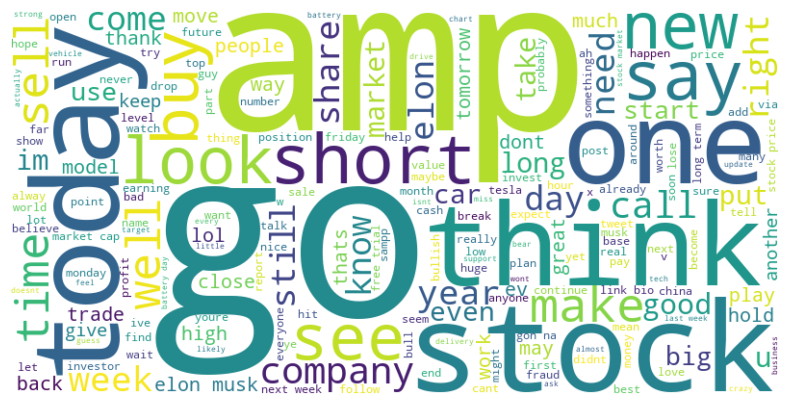

In [200]:
# Join tweets together
wordcloud_words = ' '.join(tweet_df['cleaned_tweet'])

# Generate the word cloud from the all words variable
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_words)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment Scoring

In [201]:
def analyze_sentiment(tweet):
    # Analyze sentiment using TextBlob
    blob = TextBlob(tweet)
    
    # Retrieve the sentiment polarity score
    polarity_score = blob.sentiment.polarity
    
    return polarity_score

In [202]:
# Checking for null entries as a result of cleaning tweets
null_values = tweet_df.isnull().sum()
print("Null values in each column: ")
print(null_values)

Null values in each column: 
date              0
tweet             0
retweets_count    0
cleaned_tweet     0
dtype: int64


In [203]:
# Drop null values
tweet_df.dropna(inplace=True)

In [204]:
# Start the timer
start_time = time.time()

# Apply sentiment scoring to each tweet
tweet_df['sentiment_score'] = tweet_df['cleaned_tweet'].apply(lambda x: analyze_sentiment(x))

# End the timer
end_time = time.time()

# Calculate time taken in minutes
execution_time = round((end_time - start_time)/60, 2)

print("Execution time: ", execution_time, 'minutes')

tweet_df.head()

Execution time:  0.26 minutes


date                                              tweet  \
0  2020-01-02  Fun fact: Audi registered more E-Tron's in the...   
1  2020-01-02  That MF TSLA stock at 420.. I watch that shit ...   
2  2020-01-02  @ICannot_Enough And on June 5 th 2019 within 2...   
3  2020-01-02  Tesla is gaining momentum in Taiwan 🇹🇼 @TeslaO...   
4  2020-01-02  @Schuldensuehner Now extrapolate these numbers...   

   retweets_count                                      cleaned_tweet  \
0               2  fun fact audi registered etrons netherlands su...   
1               0        mf stock watch shit go damn year miss curve   
2               0  june th within day low reply teslacharts never...   
3              15                               gain momentum taiwan   
4               0  extrapolate number another two year consider m...   

   sentiment_score  
0           0.1500  
1          -0.2000  
2           0.2667  
3           0.0000  
4           0.7500

### Exploratory Sentiment Data Analysis

#### Key Statistics

In [205]:
tweet_df['sentiment_score'].describe()

count   113741.0000
mean         0.0764
std          0.2369
min         -1.0000
25%          0.0000
50%          0.0000
75%          0.1600
max          1.0000
Name: sentiment_score, dtype: float64

#### Distributions

In [206]:
# Create the histogram plot
fig = go.Figure(data=[go.Histogram(x=tweet_df['sentiment_score'], nbinsx=20)])

# Update the layout
fig.update_layout(
    title='Distribution of Sentiment Scores',
    xaxis_title='Sentiment Score',
    yaxis_title='Number of tweets'
)

# Show the plot
fig.show()


EXPLAIN THAT WE HAVAE LOTS AND LOTS OF TWEETS, NOT ALL GOING TO BE SUPER RELEVANT/NEUTRAL

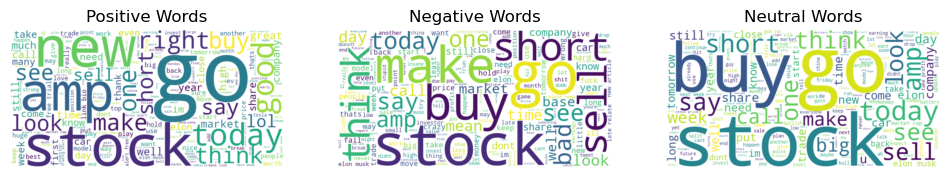

In [207]:
# Filter sentiment score by positive, neutral and negative
positive_tweets = tweet_df[tweet_df['sentiment_score'] > 0.05]['cleaned_tweet']
neutral_tweets = tweet_df[(tweet_df['sentiment_score'] >= -0.05) & (tweet_df['sentiment_score'] <= 0.05)]['cleaned_tweet']
negative_tweets = tweet_df[tweet_df['sentiment_score'] < -0.05]['cleaned_tweet']

# Join tweets together
wordcloud_positive_words = ' '.join(positive_tweets)
wordcloud_neutral_words = ' '.join(neutral_tweets)
wordcloud_negative_words = ' '.join(negative_tweets)

# Generate the word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_positive_words)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_neutral_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_negative_words)

# Display the word clouds using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Words')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Words')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Words')
plt.axis('off')

plt.show()

In [208]:
# Convert the date column to datetime format
tweet_df['date'] = pd.to_datetime(tweet_df['date'])

# Extract the date component (leaving the time)
tweet_df['day'] = tweet_df['date'].dt.date

# Filter out rows where sentiment score is less than -0.05 or greater than 0.05
tweet_df_filtered = tweet_df[(tweet_df['sentiment_score'] < -0.05) | (tweet_df['sentiment_score'] > 0.05)]

# Calculate the mean sentiment score per day
daily_sentiment_df = tweet_df_filtered.groupby('day')['sentiment_score'].mean().reset_index()

# Set the 'day' column as the index
daily_sentiment_df.set_index('day', inplace=True)
# Calculate the rolling average with a window size of your choice
window_size = 5 # Choose an appropriate window size
daily_sentiment_df['rolling_sentiment_score'] = daily_sentiment_df['sentiment_score'].rolling(window=window_size).mean()
# Drop any NaN values resulting from the rolling operation
daily_sentiment_df.dropna(inplace=True)
daily_sentiment_df.head()

sentiment_score  rolling_sentiment_score
day                                                 
2020-01-05           0.1428                   0.1784
2020-01-06           0.1371                   0.1578
2020-01-07           0.1030                   0.1410
2020-01-08           0.1184                   0.1347
2020-01-09           0.1560                   0.1315

In [209]:
daily_sentiment_df['sentiment_score'].describe()

count   363.0000
mean      0.1624
std       0.0383
min       0.0529
25%       0.1394
50%       0.1612
75%       0.1833
max       0.4008
Name: sentiment_score, dtype: float64

In [210]:
# Create the histogram plot
fig = go.Figure(data=[go.Histogram(x=daily_sentiment_df['sentiment_score'], nbinsx=20)])

# Update the layout
fig.update_layout(
    title='Distribution of Average Daily Sentiment Scores',
    xaxis_title='Sentiment Score',
    yaxis_title='Frequency'
)

# Show the plot
fig.show()


#### Trends Over Time

In [211]:
# Create a line plot of average daily sentiment over time
fig = go.Figure()

# Add the line plot for average daily sentiment over time
daily_sentiment_trace = go.Scatter(x=daily_sentiment_df.index,
                                  y=daily_sentiment_df['rolling_sentiment_score'],
                                  mode='lines',
                                  name='Sentiment Score')
# Add the trace
fig.add_trace(daily_sentiment_trace)

# Update the layout
fig.update_layout(
    title='Average Daily Sentiment Score Over Time',
    xaxis_title='Date',
    yaxis_title='Average Sentiment Score'
)

# Show the plot
fig.show()

In [212]:
# Create subplots to plot sentiment score on top of price movements
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Add the relevant traces to the correct subplot
fig.add_trace(daily_sentiment_trace, row=1, col=1)
fig.add_trace(candlestick_trace, row=2, col=1)

# Update the layout
fig.update_yaxes(title_text='Average Sentiment Score', row=1, col=1)
fig.update_yaxes(title_text='Price', row=2, col=1)
fig.update_layout(title='Daily Average Sentiment Score and Price Over Time', xaxis_rangeslider_visible=False)

# Show the figure
fig.show()


#### Correlations Among Variables

In [213]:
# Merge the tesla dataframe with the sentiment score dataframe
tsla_sentiment_df = tsla_df.merge(daily_sentiment_df, how='left', left_index=True, right_index=True)
# Drop rows with NaN values in the rolling_sentiment_score column
tsla_sentiment_df.dropna(subset=['rolling_sentiment_score'], inplace=True)
tsla_sentiment_df.head()

Open    High     Low   Close     Volume  EMA  STD  Volume_SMA  \
Date                                                                          
2020-01-06 29.3647 30.1040 29.3333 30.1027  151995000  NaN  NaN         NaN   
2020-01-07 30.7600 31.4420 30.2240 31.2707  268231500  NaN  NaN         NaN   
2020-01-08 31.5800 33.2327 31.2153 32.8093  467164500  NaN  NaN         NaN   
2020-01-09 33.1400 33.2533 31.5247 32.0893  426606000  NaN  NaN         NaN   
2020-01-10 32.1193 32.3293 31.5800 31.8767  194392500  NaN  NaN         NaN   

            Volume_STD  sentiment_score  rolling_sentiment_score  
Date                                                              
2020-01-06         NaN           0.1371                   0.1578  
2020-01-07         NaN           0.1030                   0.1410  
2020-01-08         NaN           0.1184                   0.1347  
2020-01-09         NaN           0.1560                   0.1315  
2020-01-10         NaN           0.1664                   0.1362

In [214]:
# Define the correlation matrix
correlation_matrix = tsla_sentiment_df[['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_score']].corr()

correlation_matrix

Open    High     Low   Close  Volume  sentiment_score
Open             1.0000  0.9987  0.9984  0.9972 -0.3698           0.1982
High             0.9987  1.0000  0.9981  0.9989 -0.3514           0.1954
Low              0.9984  0.9981  1.0000  0.9984 -0.3882           0.2012
Close            0.9972  0.9989  0.9984  1.0000 -0.3647           0.1953
Volume          -0.3698 -0.3514 -0.3882 -0.3647  1.0000          -0.1846
sentiment_score  0.1982  0.1954  0.2012  0.1953 -0.1846           1.0000

### Model Selection and Training with Sentiment Scoring

#### Hyperparameter Tuning

In [215]:
# Choose the number of days used to predict next day's close price
window_size = 5

# Extract the features
features = tsla_sentiment_df[['Open', 'High', 'Low', 'Close', 'Volume','rolling_sentiment_score']].values

# Retrieve the number of features
num_features = features.shape[1]

# Create the sliding window dataset for LSTM
X, y = create_lstm_dataset(features, window_size)

X_train, X_test, y_train, y_test, dates_test, X_scaler, y_scaler = create_training_data(X, y, window_size, num_features)

hyperparameters = tune_lstm_hyperparameters(X_train, y_train, X_test, y_test, window_size, num_features)

  0%|                                   | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step      

  3%|▏     | 1/30 [00:02<01:02,  2.17s/trial, best loss: 0.0025985099734610146]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

  7%|▍     | 2/30 [00:10<02:45,  5.92s/trial, best loss: 0.0025985099734610146]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      

 10%|▌     | 3/30 [00:16<02:42,  6.00s/trial, best loss: 0.0025985099734610146]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 13%|▊     | 4/30 [00:22<02:33,  5.89s/trial, best loss: 0.0025985099734610146]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      

 17%|█▏     | 5/30 [00:26<02:11,  5.25s/trial, best loss: 0.002440092375896298]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      

 20%|█▏    | 6/30 [00:32<02:09,  5.39s/trial, best loss: 0.0018315356355930708]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step      

 23%|█▍    | 7/30 [00:35<01:49,  4.75s/trial, best loss: 0.0018315356355930708]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 27%|█▌    | 8/30 [00:43<02:03,  5.63s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 30%|█▊    | 9/30 [00:45<01:37,  4.66s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      

 33%|█▋   | 10/30 [00:51<01:40,  5.04s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 37%|█▊   | 11/30 [01:00<02:00,  6.32s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step      

 40%|██   | 12/30 [01:07<01:52,  6.27s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step      

 43%|██▏  | 13/30 [01:13<01:45,  6.22s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 47%|██▎  | 14/30 [01:16<01:24,  5.25s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      

 50%|██▌  | 15/30 [01:25<01:39,  6.63s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step      

 53%|██▋  | 16/30 [01:27<01:12,  5.18s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 57%|██▊  | 17/30 [01:30<00:56,  4.32s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 60%|███  | 18/30 [01:35<00:53,  4.50s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      

 63%|███▏ | 19/30 [01:41<00:55,  5.03s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      

 67%|███▎ | 20/30 [01:50<01:02,  6.22s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step      

 70%|███▌ | 21/30 [01:55<00:53,  5.99s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      

 73%|███▋ | 22/30 [01:59<00:43,  5.42s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 77%|███▊ | 23/30 [02:08<00:44,  6.33s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step      

 80%|████ | 24/30 [02:12<00:33,  5.57s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      

 83%|████▏| 25/30 [02:20<00:31,  6.28s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 87%|████▎| 26/30 [02:25<00:23,  5.94s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step      

 90%|████▌| 27/30 [02:29<00:16,  5.47s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

 93%|████▋| 28/30 [02:33<00:10,  5.03s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step      

 97%|████▊| 29/30 [02:40<00:05,  5.55s/trial, best loss: 0.0014517444506597793]

C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step       
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step      
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step      

100%|█████| 30/30 [02:45<00:00,  5.52s/trial, best loss: 0.0014517444506597793]
Best hyperparameters: {'batch_size': 27.0, 'epochs': 120.0, 'units': 275.0}


#### Model Training

In [216]:
predictions = predict_lstm_model(X_train, y_train, X_test, y_test, window_size, num_features, hyperparameters)
predictions = y_scaler.inverse_transform(predictions).flatten()
y_test_actual = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create the trace for the actual values
actual_trace = go.Scatter(
    x=dates_test,
    y=y_test_actual,
    mode='lines',
    name='Actual Values'
)

# Create the trace for the predicted values
predicted_trace = go.Scatter(
    x=dates_test,
    y=predictions,
    mode='lines',
    name='Predicted Values'
)

# Create the layout
layout = go.Layout(
    title='Actual vs Predicted Closing Prices with Sentiment Scores',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price')
)

# Create the figure
fig = go.Figure(data=[actual_trace, predicted_trace], layout=layout)

# Show the plot
fig.show()

# Calculate MAE using actual values (not normalized values)
mae = calculate_mae(y_test_actual, predictions)
print("Mean Absolute Error: ", round(mae, 2))

# Calculate MSE using actual values (not normalized values)
mse = calculate_mse(y_test_actual, predictions)
print("Mean Squared Error: ", round(mse, 2))

Epoch 1/120


C:\Users\Philip\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0500
Epoch 2/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 
Epoch 4/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013     
Epoch 6/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 8/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 
Epoch 9/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 
Epoch 13/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011     
Epoch 14/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 
Epoch 15/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 
Epoch 16/120
8/8 ━━━━━━━

Mean Absolute Error:  6.99
Mean Squared Error:  67.71


## Conclusions